In [1]:
# !pip install imgaug --upgrade
# !pip install albumentations --upgrade
# !pip install lmdb

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [3]:
# Mount Drive if on Colab
on_colab = False
if on_colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  
  FOLDERNAME = 'chow chow/trainer/'
  assert FOLDERNAME is not None, "[!] Enter the foldername."

  import sys
  sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

  %cd drive/My\ Drive/$FOLDERNAME/

In [4]:
import util
import model

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import numpy as np
import imgaug as ia
import sklearn

import os
from os.path import isfile 
from datetime import datetime
import time
import pickle
import pathlib

In [5]:
# Define paths to data
d = '../data/'
dirs = {
    'imgs_train':     d + 'train_data/',
    'imgs_val': d + 'val_data/',
    'imgs_test':d + "test_data/",
    'lmdb_train':d + 'train_lmdb',
    'lmdb_val':  d + 'val_lmdb',
    'lmdb_test': d + 'test_lmdb'
}

files = {
    'train_pkl':    d + "lmdb_train_out.pkl",
    'val_pkl':      d + "lmdb_val_out.pkl",
    'test_pkl':     d + "lmdb_test_out.pkl",
    'classes_pkl':  d + "classes1M.pkl",
    'rvocab_pkl':   d + "vocab.txt",
    'pt_pkl':       d + 'partition.pkl', # image ids
    'lb_pkl':       d + 'labels.pkl', # labels
    'ingr_pkl':     d + 'ingredients.pkl', # ingredient names
    'ingr_id2id_pkl':   d + 'ingr_id2id.pkl', # ingredient old to new id
    # 'cl_pkl':       d + 'classes.pkl', # class names
}

In [6]:
# Read LMDB into pkl
# TODO: add train dir, out file
if not (isfile(files['train_pkl']) and isfile(files['val_pkl']) and isfile(files['test_pkl'])):
    print("LMDBs processing into pkls")
    lmdb_train_out = util.read_lmdb(dirs['lmdb_train'])
    pickle.dump(lmdb_train_out, open(files['train_pkl'], 'wb'))
    
    lmdb_val_out = util.read_lmdb(dirs['lmdb_val'])
    pickle.dump(lmdb_val_out, open(files['val_pkl'], 'wb'))
    
    lmdb_test_out = util.read_lmdb(dirs['lmdb_test'])
    pickle.dump(lmdb_test_out, open(files['test_pkl'], 'wb'))
else:
    print("LMDBs already saved as pkls")


LMDBs already saved as pkls


In [6]:
# Allows memory usage > 15.5 GB (size of labels array during util.load_data)
# From https://stackoverflow.com/a/61963727, https://stackoverflow.com/a/57511555
# !echo 1 | sudo tee /proc/sys/vm/overcommit_memory

1


In [7]:
# Load data
if not (isfile(files['pt_pkl']) and isfile(files['lb_pkl']) and isfile(files['ingr_pkl'])):
    print("Datasets processing for the 1st time into pkls")
    partition, labels, ingrs = util.load_data(dirs, files)
    
    pickle.dump(partition, open(files['pt_pkl'], "wb"))
    pickle.dump(labels, open(files['lb_pkl'], "wb"))
    pickle.dump(ingrs, open(files['ingr_pkl'], "wb"))
    print("Datasets loaded")
else:
    partition = pickle.load(open(files['pt_pkl'], "rb"))
    labels = pickle.load(open(files['lb_pkl'], "rb"))
    ingrs = pickle.load(open(files['ingr_pkl'], "rb"))
    print("Datasets loaded from pkls")


Datasets loaded from pkls


In [8]:
# Create data generators
data_params = {'dim': (224,224),
              'batch_size': 128,
              'n_ingrs': len(ingrs),
              'n_channels': 3,
              'shuffle': True}

image_dir_tr = dirs['imgs_train']
image_dir_val = dirs['imgs_val']

gen_tr = model.DataGenerator(partition['train'], labels, image_dir_tr, **data_params)
gen_val = model.DataGenerator(partition['validation'], labels, image_dir_val, **data_params)

Seconds needed to fetch, aug, encode one batch of size 512: 70.87, 2.40, 0.01, TOTAL 73.28


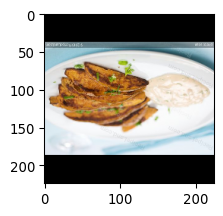

[0. 0. 0. ... 0. 0. 0.]


KeyboardInterrupt: 

In [9]:
# Check generator and fetching speed
X, y = gen_tr.__getitem__(0)
for i, img in enumerate(X):
    ia.imshow(img)
    print(y[i])
    break

X, y = gen_val.__getitem__(0)
for i, img in enumerate(X):
    ia.imshow(img)
    print(y[i])
    break

In [10]:
# Change for each experiment
trial_name = 'stage1_resnet'
is_init = True # choose stage of training
model_name = 'resnet'
best_init_name = '{}_{}_{}'.format('09_05', '2', 'stage1_resnet') # select stage 1 weights to use

# Name experiment
today = datetime.now().strftime('%m_%d')
trial_ct = len(list(pathlib.Path('logs/').rglob(today+'*/'))) + 1
exp_name =  '{}_{}_{}'.format(today, trial_ct, trial_name)
logdir = 'logs/' + exp_name
print('Running experiment ', exp_name)

# Stage 1 training
# Choose parameters for initializing the last layer
init_params = {
    'model_name': model_name,
    'lr': 1e-2,
    'input_shape': (*data_params['dim'], data_params['n_channels']),
    'num_ingrs': len(ingrs),
    'eps': 10, 
}

# Stage 2 training
# Choose parameters for transfer learning on the pre-trained model
tl_params = {
    'lr': 1e-5,
    'num_unfreeze': 4, # num layers to unfreeze from top of pre-trained model
    'init_path': '{}/{}/{}'.format('logs', best_init_name, 'best_epoch_model.h5'),
    'eps': 100,
}

# Load model
if is_init:
    print('Loaded stage 1 model')
    nn = model.create_init_model(init_params)
    eps = init_params['eps']
else:
    print('Loaded stage 2 model')
    nn = model.create_tl_model(tl_params)
    eps = tl_params['eps']

Running experiment  09_05_3_stage1_resnet
Loaded stage 1 model


In [11]:
# Define callbacks
lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: lr + 0.02 * (0.5 ** (1 + epoch)),
    verbose=True)

tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

class MetricsHistory(Callback):
    def __init__(self):
        self.best_score = -1
        self.start_time = time.time()
        self.start_epoch = time.time()
    
    def on_batch_begin(self, epoch, logs={}):
        self.start_epoch = time.time()
    
    def on_batch_end(self, epoch, logs={}):
        print("Seconds to finish batch: {:.2f}".format(time.time() - self.start_epoch))
    
    def on_epoch_begin(self, epoch, logs={}):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs={}):
        # Report train and val metric
        tr_score = logs['f1_ml']
        val_score = logs['val_f1_ml']
        print("\n\nTrain F1: {:2f} \nVal F1:   {:2f}".format(tr_score, val_score))
        
        # Report time taken to complete this epoch
        elapsed = (time.time() - self.start_time) / 60
        print("Epoch finished in {:.1f} minutes".format(elapsed))

        # Save model if better
        if val_score > self.best_score:
            print("Better validation score! Saving model ...")
            if not os.path.exists(logdir):
                os.makedirs(logdir)
            self.model.save(logdir + '/best_epoch_model.h5')
            self.best_score = val_score
        print("\n\n")
        
metrics_cb = MetricsHistory()

In [5]:
# Visualize training
# on GCP: append to ssh `-- -L 7000:localhost:7000` for port forwarding
# then locally open `localhost:7000`
%tensorboard --port=7000 --logdir logs/ # %tensorboard --logdir logs/

In [12]:
# Train
history = nn.fit(gen_tr, epochs=eps, validation_data=gen_val, 
                 callbacks=[tensorboard_cb, metrics_cb]) 
# lr_decay_cb, validation_steps=val_steps, 
# use_multiprocessing=True, workers=6

Seconds needed to fetch, aug, encode one batch of size 512: 10.01, 2.09, 0.01, TOTAL 12.10
  ...
    to  
  ['...']
Seconds needed to fetch, aug, encode one batch of size 512: 56.11, 2.20, 0.01, TOTAL 58.32
  ...
    to  
  ['...']
Train for 749 steps, validate for 160 steps
Epoch 1/10
Seconds needed to fetch, aug, encode one batch of size 512: 59.66, 2.26, 0.01, TOTAL 61.94


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Seconds to finish batch: 75.31
  1/749 [..............................] - ETA: 15:39:46 - loss: 66.7681 - f1_ml: 0.0000e+00 - prec_ml: 0.0000e+00 - recall_ml: 0.0000e+00Seconds needed to fetch, aug, encode one batch of size 512: 51.90, 2.33, 0.01, TOTAL 54.25
Seconds to finish batch: 47.86
  2/749 [..............................] - ETA: 12:47:13 - loss: 65.5829 - f1_ml: 0.0000e+00 - prec_ml: 0.0000e+00 - recall_ml: 0.0000e+00Seconds needed to fetch, aug, encode one batch of size 512: 54.97, 2.26, 0.01, TOTAL 57.24
Seconds to finish batch: 57.71
  3/749 [..............................] - ETA: 12:29:58 - loss: 66.2608 - f1_ml: 0.0000e+00 - prec_ml: 0.0000e+00 - recall_ml: 0.0000e+00Seconds needed to fetch, aug, encode one batch of size 512: 50.62, 2.20, 0.01, TOTAL 52.84
Seconds to finish batch: 53.45
  4/749 [..............................] - ETA: 12:07:38 - loss: 67.2769 - f1_ml: 0.0000e+00 - prec_ml: 0.0000e+00 - recall_ml: 0.0000e+00Seconds needed to fetch, aug, encode one batch of s

KeyError: 'val_f1_ml'

In [ ]:
# Export
nn.save(logdir + "/last_epoch_model/")

In [ ]:
# Evaluate predictions
X_s, y_s = gen_val.__getitem__(1)
for i, pred in enumerate(nn.predict(X_s)):    
    truth = y_s[i]
    img = X_s[i]
    
    true_class_id = np.where(truth == 1)[0]
    pred_class_id = np.where(pred > 1e-9)[0]
    
    print("Image ", i)
    print("True: ", [ingrs[x] for x in true_class_id])
    print("Predicted: ", [ingrs[x] for x in pred_class_id])
    print()
    print(true_class_id)
    print(pred_class_id)
    print("Predicted logit: ", pred[pred_class_id])
    ia.imshow(img)